In [5]:
# setup
# file
import os

# Data Processing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# explain
import seaborn as sns
import shap

# folder
folder_input = '02_input'



In [6]:
# import data
# original data
org = pd.read_csv(os.path.join('..', folder_input, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))

# check any missing value
org.isnull().sum()


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
# data cleansing

# target (turn to bool)
cleaned_data = org.copy()
cleaned_data['Churn'] = cleaned_data['Churn'] == "Yes"

# total charges - " " to 0
cleaned_data['TotalCharges'] = cleaned_data['TotalCharges'].str.replace(" ", "0", case=False, regex=False)
cleaned_data = cleaned_data.astype({'TotalCharges': 'float64'})

# drop useless cols
cleaned_data = cleaned_data.drop(
    labels=['customerID'],
    axis=1
)

# cleaned_data.head()

In [8]:
# train vs test
# seperate target from predictors
X = cleaned_data.copy()            # use copy, not to affect original dataset
y = X.pop('Churn')        # y = "churn", and delete churn from X

# train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [9]:
# preprocessing for categorical data
cleaned_data.info()

# select categorical columns
# PS: [categorical_cols] mean == True
categorical_cols = X_train.dtypes == 'object'
categorical_cols = list(categorical_cols[categorical_cols].index)  
categorical_cols    

# one hot encoder
# PS: The one hot encoder output is a series, need to turn to dataframe
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(X_test[categorical_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# add back colnames
OH_cols_train.columns = OH_encoder.get_feature_names_out()
OH_cols_test.columns = OH_encoder.get_feature_names_out()


# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(categorical_cols, axis=1)
num_X_test = X_test.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_test = pd.concat([num_X_test, OH_cols_test], axis=1)


X_train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3296,0,24,49.30,1233.25,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6397,1,54,65.25,3529.95,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6043,0,3,40.15,130.75,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5309,0,61,20.25,1278.80,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3000,0,12,84.45,1059.55,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [10]:
# preprocessing for numerical data
# select numericial columns
numericial_cols = cleaned_data.dtypes.isin(['int64', 'float64'])
numericial_cols = list(numericial_cols[numericial_cols].index)  
numericial_cols

# scaler
num_encoder = StandardScaler()
num_cols_train = pd.DataFrame(num_encoder.fit_transform(X_train[numericial_cols]))
num_cols_test = pd.DataFrame(num_encoder.fit_transform(X_test[numericial_cols]))

# One-hot encoding removed index; put it back
num_cols_train.index = X_train.index
num_cols_test.index = X_test.index

# add back colnames
num_cols_train.columns = num_encoder.get_feature_names_out()
num_cols_test.columns = num_encoder.get_feature_names_out()

# Remove numerical  columns (will replace with encoding)
cat_X_train = X_train.drop(numericial_cols, axis=1)
cat_X_test = X_test.drop(numericial_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([cat_X_train, num_cols_train], axis=1)
X_test = pd.concat([cat_X_test, num_cols_test], axis=1)


X_train.head()



,SeniorCitizen,tenure,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MonthlyCharges,TotalCharges
3296,0,24,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.514314,-0.460284
6397,1,54,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.017840,0.556508
6043,0,3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.819594,-0.948382
5309,0,61,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,-1.483535,-0.440119
3000,0,12,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.658427,-0.537185


In [11]:
# xgboost
xgbmodel = XGBClassifier(n_estimators = 1000)
xgbmodel.fit(
    X_train,
    y_train
)

# prediction
preds = xgbmodel.predict(X_test)

In [12]:
# evaluation
accuracy_score(y_test, preds)

0.7654741624077229

In [13]:
# confusion matrix
confusion_matrix(y_test, preds)

array([[1126,  172],
       [ 241,  222]], dtype=int64)

In [14]:
# classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.82      0.87      0.85      1298
        True       0.56      0.48      0.52       463

    accuracy                           0.77      1761
   macro avg       0.69      0.67      0.68      1761
weighted avg       0.76      0.77      0.76      1761



<Axes: >

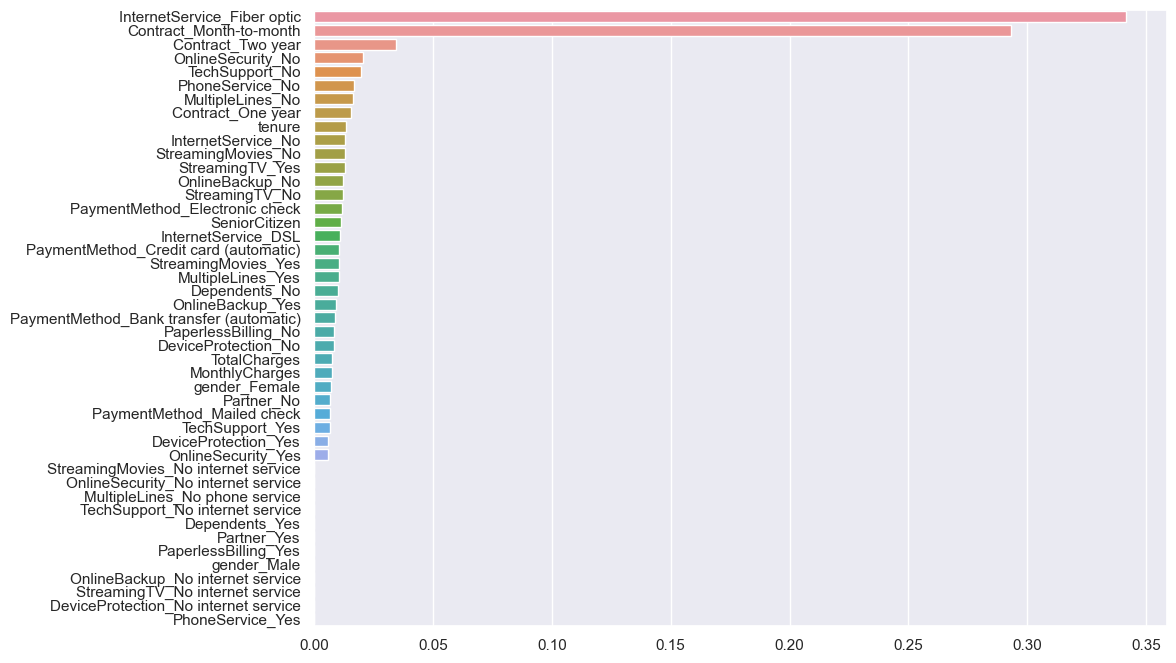

In [15]:
# feature importance
xgb_importance = pd.Series(xgbmodel.feature_importances_, index=X_train.columns).sort_values(ascending= False)
xgb_importance

# plot it
sns.set(rc={'figure.figsize':(11,8)})
sns.barplot(x = xgb_importance.values,
            y = xgb_importance.index)